# Analisando os filmes do IMDB

In [137]:
import matplotlib.pyplot as plt
import re
from functools import reduce
from pymongo import MongoClient

db_client = MongoClient('mongo', 27017)
db = db_client.imdb_data

## Sobre os dados obtidos 

### Genêro dos filmes

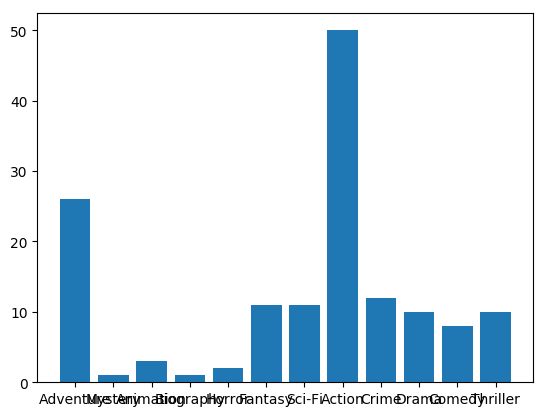

In [183]:
genres = db.movies_data.distinct("genres")
data = {}

for genre in genres:
    data[genre] = db.movies_data.count_documents({ "genres" : genre})

names = list(data.keys())
values = list(data.values())    
    
fig = plt.bar(names, values)

# Respostas

## Qual a probabilidade de uma mulher ser diretora do filme?

In [102]:
pipeline = [{'$lookup': 
                {'from' : 'directors_data',
                 'localField' : 'directors_ids',
                 'foreignField' : 'id',
                 'as' : 'directors'}},
            {'$unwind': '$directors'},
             {'$match':
                 { 'directors.gender' : 'Female'}},
             {'$project': 
                {'title':1, 'directors.name':1, 'directors.gender' : 1, "_id": 0}} 
             ]
female_movies = 0
for movie in db.movies_data.aggregate(pipeline):
    female_movies += 1
total_movies = db.movies_data.count_documents({})

percentage = female_movies / total_movies * 100

print("{}%".format(percentage))

7.000000000000001%


## Qual o tempo de duração médio dos filmes obtidos?

In [131]:
total_runtime = db.movies_data.aggregate([{ '$group': {
                                '_id' : 0 , 'sum': { '$sum': "$runtime" } 
                            }},
                          {'$project': { 'sum': 1, '_id': 0 }}
                         ])
total_movies = db.movies_data.count_documents({})
for total in total_runtime :
    avg = total['sum']/ total_movies

print(avg)

122.96


## Qual a probabilidade de cada filme em seu gênero ter uma avaliação superior a 8?


## Qual a probabilidade de um filme ter avaliação superior a 8, considerando que ele não possui um diretor americano?


In [180]:
pipeline = [{'$lookup': 
                {'from' : 'directors_data',
                 'localField' : 'directors_ids',
                 'foreignField' : 'id',
                 'as' : 'directors'}},
            {'$unwind': '$directors'},
             {'$match':
                 { 'imdb_rating': { '$gte' : 8} ,
                  'directors.nationality' : {'$not' : re.compile("USA|Unknown")} ,
                 }
             },
                {'$count': 'title'},
             {'$project': 
                {'title': 1, "_id": 0}} 
             ]
for movies in db.movies_data.aggregate(pipeline):
    intersection = movies['title']
gte_than_eight = db.movies_data.count_documents({ 'imdb_rating': { '$gte' : 8} })
probability = intersection/gte_than_eight*100

print("{}%".format(probability))

50.0%


## Quais são os diretores preferidos?
